# Objective - Forecast Close price of Tata Motors Closing Price using (i) Auto -ARIMA & (ii) FBprophet

### Import libraries

In [1]:
#For data
import pandas as pd
import numpy as np

#For Plotting
import matplotlib.pyplot as plt

#For ARIMA
from pmdarima import auto_arima

#For FBProphet
from fbprophet import Prophet

#Test/Train Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Tata Motors Group (Tata Motors) is a 35 billion dollar organisation. It is a leading global automobile manufacturing company. Its diverse portfolio includes an extensive range of cars, sports utility vehicles, trucks, buses and defence vehicles. Tata Motors is one of India's largest OEMs offering an extensive range of integrated, smart and e-mobility solutions

![DataSet/profile_info.jpg](DataSet/profile_info.jpg)

In [2]:
#Read data files
#Data Source : https://www.kaggle.com/rohanrao/nifty50-stock-market-data
df = pd.read_csv('DataSet/TATAMOTORS.csv')
df.set_index("Date", drop=False, inplace=True)

In [3]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2021-04-26,2021-04-26,TATAMOTORS,EQ,294.0,297.0,299.0,294.60,295.85,295.40,296.48,30583139,9.067386e+14,173282.0,3291167.0,0.1076
2021-04-27,2021-04-27,TATAMOTORS,EQ,295.4,295.7,302.5,295.10,302.10,301.50,299.05,35040532,1.047879e+15,191627.0,5215100.0,0.1488
2021-04-28,2021-04-28,TATAMOTORS,EQ,301.5,303.5,309.5,303.00,305.15,305.90,307.22,44668126,1.372278e+15,264159.0,5116568.0,0.1145
2021-04-29,2021-04-29,TATAMOTORS,EQ,305.9,308.9,310.0,301.25,302.20,301.90,304.77,36647292,1.116900e+15,186996.0,4193346.0,0.1144
2021-04-30,2021-04-30,TATAMOTORS,EQ,301.9,298.2,301.3,292.55,293.10,293.85,297.01,36121668,1.072849e+15,227806.0,7898988.0,0.2187


### The target variable to predict is the Closing Price. Closing price is the last price of the stock was at the end of the day.

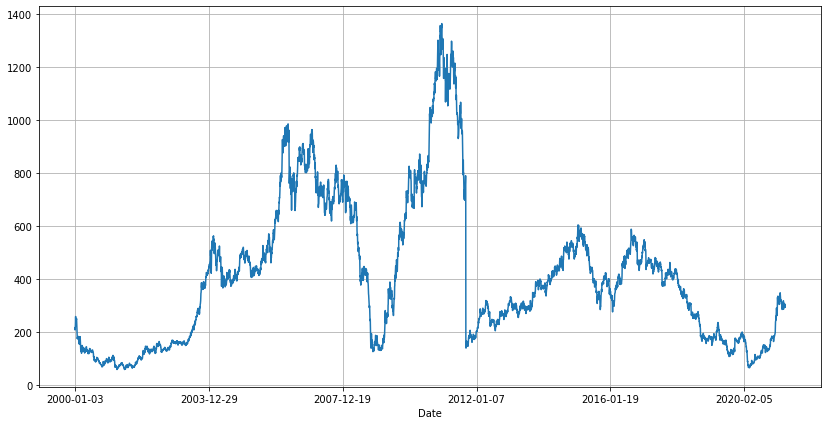

In [4]:
df.Close.plot(figsize=(14,7))
plt.grid()

### Insights
- TataMotors suffer a huge crash in 2010 followed by decline in price post 2016
- TataMotors hit it's 11-year lowest in September 2020

- We need to predict the stock price for a day, but we can't use feature values from the same day because they won't be available at the time of inference. We must employ statistics such as the mean and standard deviation of their lagged values.
- As a proxy for last week and last month metrics, we will use three sets of lagged values: one from the previous day, one from 7 days ago, and one from 30 days ago.

In [5]:
df.reset_index(drop=True, inplace=False)
lag_features = ['Prev Close','Open','High', 'Low','Last']
window1 = 3
window2 = 7
window3 = 30

In [6]:
#Mean
#alternative: use 'shift' instead of 'window+1'
df_mean_3d = df[lag_features].rolling(window = window1+1).mean() 
df_mean_7d = df[lag_features].rolling(window = window2+1).mean()
df_mean_30d = df[lag_features].rolling(window = window3+1).mean()

In [7]:
#Standard Deviation
#alternative: use 'shift' instead of 'window+1'
df_std_3d = df[lag_features].rolling(window = window1+1).std() 
df_std_7d = df[lag_features].rolling(window = window2+1).std()
df_std_30d = df[lag_features].rolling(window = window3+1).std()

In [8]:
df_std_7d.tail()

,Prev Close,Open,High,Low,Last
Date,,,,,
2021-04-26,7.195125,6.755312,5.126015,5.713690,5.159527
2021-04-27,5.516076,5.543787,5.211183,2.941384,5.166703
2021-04-28,5.435400,5.608396,5.395199,4.199484,5.485431
2021-04-29,5.727191,6.694987,4.260612,4.393781,4.331508
2021-04-30,4.253297,6.508017,4.410210,4.416204,4.626380


In [9]:
#Renaming the columns and merging with orignal dataframe
#Features = High,Low,Volume,Turnover
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"]=df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"]=df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"]=df_mean_30d[feature]
    df[f"{feature}_std_lag{window1}"]=df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"]=df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"]=df_std_30d[feature]

In [10]:
#Fill NAN Values
df.fillna(df.mean(), inplace=True)
df.set_index("Date", drop=False, inplace=True)

In [11]:
#Determining the date, day, week, & day of the week
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['Month']=df.Date.dt.month
df['Week']=df.Date.dt.week
df['Day']=df.Date.dt.day
df['Day of the week']=df.Date.dt.dayofweek

In [12]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Last_mean_lag3,Last_mean_lag7,Last_mean_lag30,Last_std_lag3,Last_std_lag7,Last_std_lag30,Month,Week,Day,Day of the week
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-26,2021-04-26,TATAMOTORS,EQ,294.0,297.0,299.0,294.60,295.85,295.40,296.48,...,295.2375,299.45000,305.270968,1.802487,5.159527,9.678807,4,17,26,0
2021-04-27,2021-04-27,TATAMOTORS,EQ,295.4,295.7,302.5,295.10,302.10,301.50,299.05,...,296.4125,299.46250,304.650000,3.943005,5.166703,9.219445,4,17,27,1
2021-04-28,2021-04-28,TATAMOTORS,EQ,301.5,303.5,309.5,303.00,305.15,305.90,307.22,...,299.0750,299.83125,304.327419,5.506738,5.485431,9.012434,4,17,28,2
2021-04-29,2021-04-29,TATAMOTORS,EQ,305.9,308.9,310.0,301.25,302.20,301.90,304.77,...,301.3250,299.01250,303.696774,3.914609,4.331508,8.416986,4,17,29,3
2021-04-30,2021-04-30,TATAMOTORS,EQ,301.9,298.2,301.3,292.55,293.10,293.85,297.01,...,300.6375,297.93750,302.911290,5.220373,4.626380,8.224726,4,17,30,4


Test Data - Until 2019
Validation Data - After 2019

In [13]:
#Test data & Validation Data
df_train = df[df.Date<'2019']
df_valid = df[df.Date>='2019']

## ARIMA
Forecasting a time series can be broadly divided into two types.

- If you use only the previous values of the time series to predict its future values, it is called Univariate Time Series Forecasting.

- And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called Multi Variate Time Series Forecasting.

ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

For further reading, visit here: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [14]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Prev Close_mean_lag3', 'Prev Close_mean_lag7',
       'Prev Close_mean_lag30', 'Prev Close_std_lag3', 'Prev Close_std_lag7',
       'Prev Close_std_lag30', 'Open_mean_lag3', 'Open_mean_lag7',
       'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7', 'Open_std_lag30',
       'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30', 'High_std_lag3',
       'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7',
       'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
       'Last_mean_lag3', 'Last_mean_lag7', 'Last_mean_lag30', 'Last_std_lag3',
       'Last_std_lag7', 'Last_std_lag30', 'Month', 'Week', 'Day',
       'Day of the week'],
      dtype='object')

In [15]:
exogenous_features = ['Prev Close_mean_lag3', 'Prev Close_mean_lag7',
       'Prev Close_mean_lag30', 'Prev Close_std_lag3', 'Prev Close_std_lag7',
       'Prev Close_std_lag30', 'Open_mean_lag3', 'Open_mean_lag7',
       'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7', 'Open_std_lag30',
       'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30', 'High_std_lag3',
       'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7',
       'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
       'Last_mean_lag3', 'Last_mean_lag7', 'Last_mean_lag30', 'Last_std_lag3',
       'Last_std_lag7', 'Last_std_lag30', 'Month', 'Week', 'Day',
       'Day of the week']

In [16]:
model=auto_arima(df_train.Close, exogenous=df_train[exogenous_features], 
                 trace=True, 
                 error_action='ignore', 
                 supress_warnings = True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])
forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=30007.250, BIC=30265.700, Time=43.897 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=30753.489, BIC=30986.094, Time=3.114 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=30692.931, BIC=30931.997, Time=35.846 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=30620.459, BIC=30859.526, Time=38.326 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=30751.565, BIC=30977.709, Time=21.644 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=30402.674, BIC=30654.663, Time=39.086 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=30372.544, BIC=30624.533, Time=43.854 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=29206.890, BIC=29471.802, Time=46.195 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=29394.502, BIC=29652.952, Time=45.017 seconds
Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=29208.614, BIC=29479.987, Time=46.521 seconds
Fit ARI

<b>The best fit ARIMA model is (3,1,5) which has the lowest AIC.</b><br>
Read more on AIC here: https://www.scribbr.com/statistics/akaike-information-criterion/

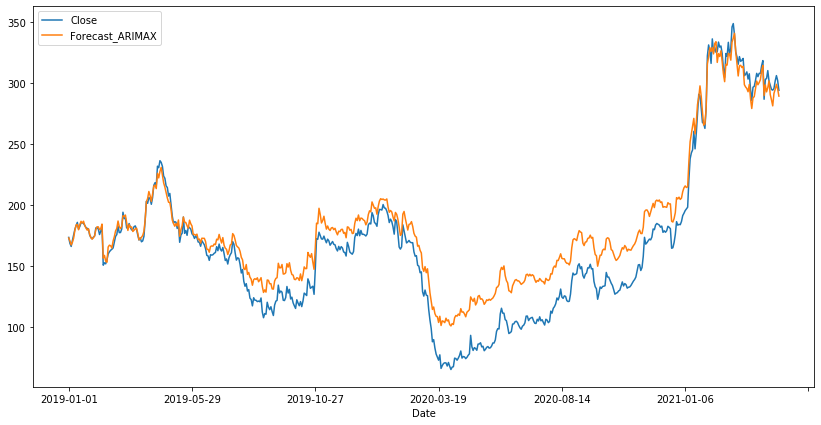

In [17]:
df_valid[['Close','Forecast_ARIMAX']].plot(figsize=(14,7))

In [18]:
print('RMSE of Auto Arimax',np.sqrt(mean_squared_error(df_valid.Close,df_valid.Forecast_ARIMAX)))
print('MAE of Auto ARIMAX',mean_absolute_error(df_valid.Close,df_valid.Forecast_ARIMAX))

RMSE of Auto Arimax 20.669041344063924
MAE of Auto ARIMAX 16.952709412802868


### Insights

The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude

Both the MAE and RMSE can range from 0 to ∞. They are negatively-oriented scores: Lower values are better.

Further reading, visit here: https://thedatascientist.com/performance-measures-rmse-mae/

## FBprophet

Prophet is an open-source time series model developed by Facebook. It was released in early 2017.

In [19]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)
    
model_fbp.fit(df_train[['Date','Close',] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))
forecast1 = model_fbp.predict(df_valid[['Date','Close'] + exogenous_features].rename(columns={"Date": "ds"}))

df_valid['Forecast_Prophet'] = forecast1.yhat.values

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


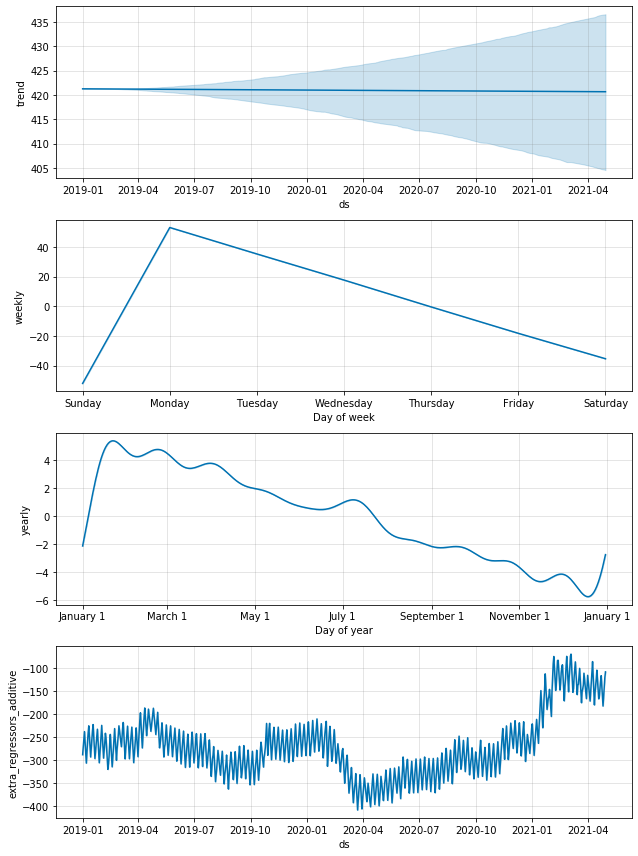

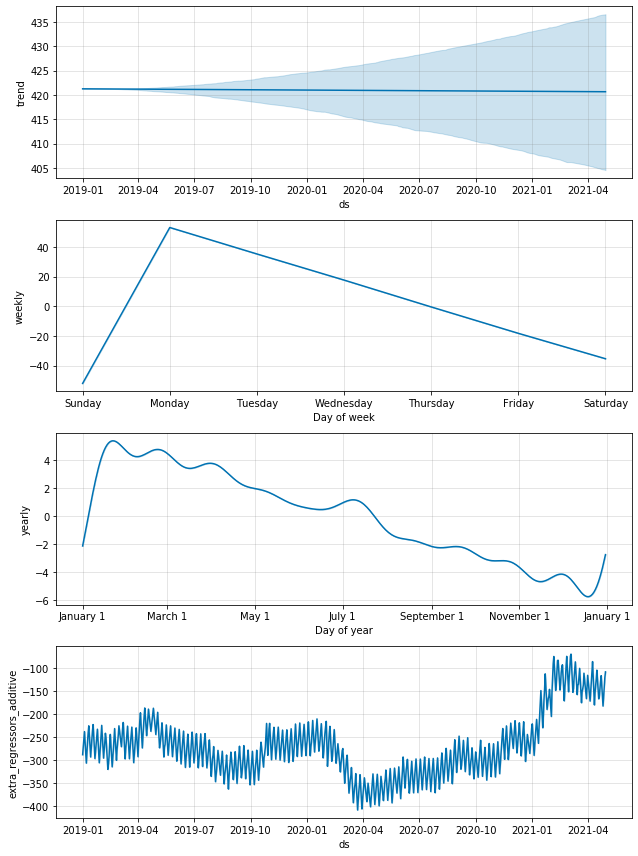

In [20]:
model_fbp.plot_components(forecast1)

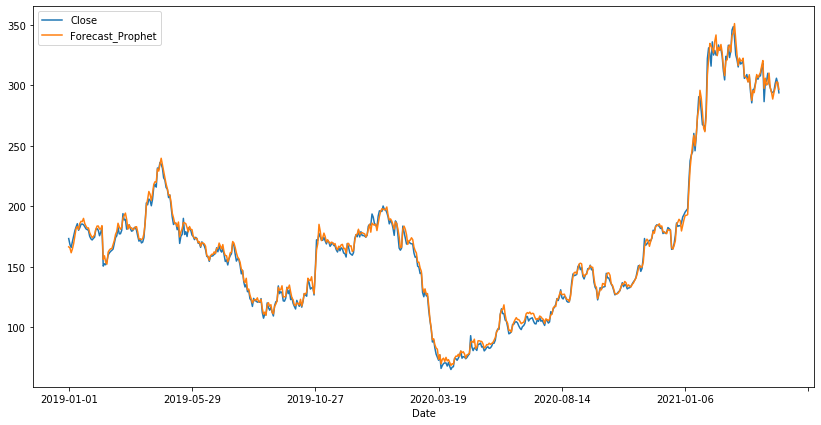

In [21]:
df_valid[["Close", "Forecast_Prophet"]].plot(figsize=(14, 7))

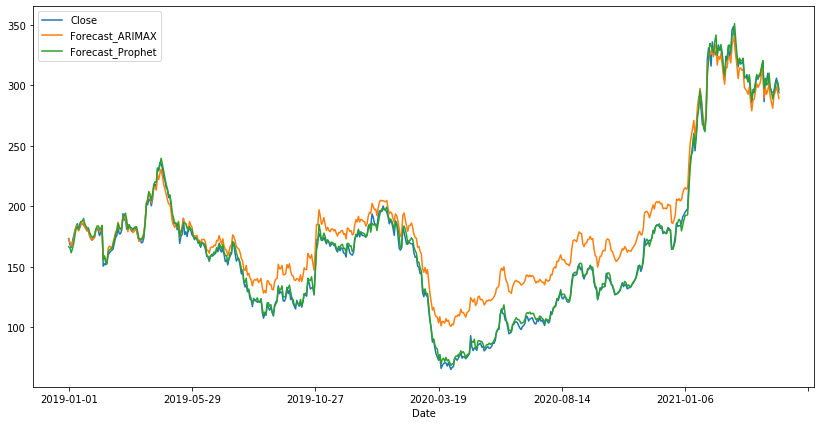

In [22]:
df_valid[["Close","Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [23]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.Close, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 20.669041344063924
RMSE of Prophet: 3.5843342933049582

MAE of Auto ARIMAX: 16.952709412802868
MAE of Prophet: 2.7065287302674927


## Inference

<h2> Since the values of RMSE and MAE of FBprophet are less than Auto Arima, we can conclude that FBprophet performed better than Auto Arima at forecasting the Time Series </h2>